## Classification of the CIFAR-10 Dataset

This is a reflective report on the universal deep learning workflow and how it is applied it in the image classification of the CIFAR-10 Dataset.

---

1. Defining the problem and Assembling a Dataset
    - The Problem
    - The Data
    - Naive Baseline
2. Choosing a Measure of Success
    - Primary Metrics
    - Additional Metrics
3. Deciding on an Evaluation Protocol
4. Preparing the Data
    - Preprocessing
    - Post-Processing & Verification
5. Developing and Comparing Two Small Models
    - Model 1 (two hidden 16-unit layers)
    - Model 2 (one hidden 32-unit layer)
    - Comparison & Discussion
6. Scaling up: Overfitting Experiment
    - Model 3 (four dense 128-unit layers)
    - Results & Discussion
7. Regularizing and Hyperparameter Tuning
    - Experiments Setup
    - Experiments results & Discussion
8. Final Model and Test Evaluation
    - Model 4 (Best Hyper-parameters)
    - Results & Discussion

### 1 | Defining the problem and Assembling a Dataset
---
##### The Problem
The CIFAR-10 Consists of 60,000 32x32 color images labeled into 10 classes, with 50,000 for training and 10,000 for testing. Classes include: airplane, car, bird, cat, deer, dog, frog, horse, ship, truck.

Models trained on the CIFAR-10 dataset and other similar datasets have real world applications in object recognization for autonomous systems such as robotics and autonomous driving. The models used in object recognition are critical to the functionality of these systems as a miss-classified or un-recognized object can cause the system to make decisions on false information potentially leading to human harm in both robotics and autonomous driving.

The CIFAR-10 dataset represents a multi-class single label problem, where the objective of the model is to learn intermediate representations of the data that facilitate a single label being assigned per input sample.

##### The Data
The 60,000 samples in the CIFAR-10 dataset are split into 10 classes, encoded as an integer 0-9. We can check the balance of these classes by visualizing the distribution of the number of samples assigned to each class.

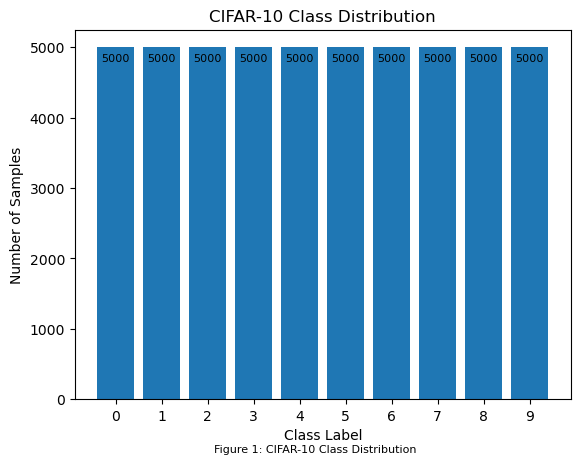

In [48]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# load cifar-10 dataset (if not already loaded)
if 'cifar10' not in globals():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# plot class distribution
classes, counts = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots()
ax.bar(classes, counts)
ax.set_xticks(classes)
ax.set_xticklabels(classes)
ax.set_xlabel('Class Label')
ax.set_ylabel('Number of Samples')
ax.set_title('CIFAR-10 Class Distribution')
# figure text
fig.text(0.5,
         0,
         'Figure 1: CIFAR-10 Class Distribution',
         ha='center',
         fontsize=8)
# add counts on top of bars
for i, count in zip(classes, counts):
    ax.text(i,
            count -200,
            str(count),
            ha='center',
            fontsize=8)
plt.show()

CIFAR-10 contains 10 classes with exactly 5,000 images per class in the standard training set, implying a perfectly balanced class distribution. Class imbalance is a common source of bias in supervised learning: when some classes are over-represented, a neural network may learn internal representations that disproportionately favour those classes, while under-represented classes may contribute insufficient gradient signal for robust feature learning. Where imbalance exists, standard remedies include oversampling minority classes, undersampling majority classes, or applying class-weighted losses so that errors on minority classes are penalized more heavily during gradient-based optimization.

Each CIFAR-10 sample is a 32×32 RGB image, which may be viewed as a 32×32×3 tensor. Although the raw data are stored as 8-bit integers with values in the range 0–255, neural networks typically operate more effectively on continuous inputs; therefore, pixel intensities are commonly rescaled to the range 0–1 (or alternatively standardized). The bounded nature of image data makes this normalization straightforward and helps avoid poorly conditioned optimization. In particular, if features are on substantially different scales, early training can become unstable because parameter updates may be dominated by gradients associated with high-magnitude features, slowing convergence or producing erratic learning dynamics.

A further characteristic of image data is the strong local correlation between neighbouring pixels. However, fully connected networks require images to be flattened into a one-dimensional vector, which removes explicit spatial structure and encourages the model to treat the input as an unstructured set of features. This preprocessing choice discards inductive biases that could otherwise be exploited. Nevertheless, high accuracy can still be achieved with multilayer perceptrons on some vision tasks (e.g., MNIST), indicating that spatial structure, while informative, is not always essential for reasonable performance at small image resolutions.

For experimentation, the dataset will be partitioned into 40,000 training samples, 10,000 validation samples, and 10,000 test samples. Models will be trained on the training set, while hyperparameters are selected using validation performance. The final configuration will then be retrained using the combined training and validation data before evaluation on the held-out test set. This protocol reduces the risk of test-set leakage and provides an unbiased estimate of generalization to previously unseen data.

##### Naive Baseline

To contextualize performance, a baseline model will be used. A suitable baseline is a single-layer softmax classifier (Dense(10)), equivalent to multinomial logistic regression on flattened pixel features. This model should exceed random guessing while remaining sufficiently simple that subsequent improvements can be attributed to increased representational capacity rather than evaluation artefacts.

In [47]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.utils import to_categorical

# one-hot encode labels
y_train_oh = to_categorical(y_train, num_classes=10)
y_test_oh = to_categorical(y_test, num_classes=10)

# build simple feedforward neural network
model = Sequential()
model.add(Input(shape = (32, 32, 3))) # CIFAR-10 image shape
model.add(Flatten()) # flatten 2D images to 1D vectors
model.add(Dense(10, activation='softmax')) # output layer for 10 classes

# compile model
model.compile(optimizer='SGD',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        30,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# train model
model.fit(X_train,
          y_train_oh,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, y_test_oh))

# evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/10


c:\Users\wsidn\.conda\envs\S3_Neural_Networks\Lib\site-packages\keras\src\backend\tensorflow\nn.py:675: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2142 - loss: 84741.0625 - val_accuracy: 0.2579 - val_loss: 49771.5469
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2393 - loss: 73487.4688 - val_accuracy: 0.2709 - val_loss: 70707.2578
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2508 - loss: 70451.1094 - val_accuracy: 0.2604 - val_loss: 53582.1094
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2519 - loss: 69370.2891 - val_accuracy: 0.1918 - val_loss: 103655.5625
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2567 - loss: 68287.2656 - val_accuracy: 0.2828 - val_loss: 46255.9570
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2600 - loss: 66693.7891 - val_accuracy: 0.2578 - val_loss: 67498.6250
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2638 - loss: 66339.8203 - val_accuracy: 0.2607 - val_loss: 58180.0117
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s

The baseline model achieves an accuracy of 21.6%. This is better than random guessing, which would achieve around 10% accuracy, and will serve well as a gague for the success of the more advanced models.

### 2 | Choosing a Measure of Success
---



##### Primary Metrics
Accuracy is the standard and accepted primary measure of success on a balanced dataset. Accuracy is the proportion of correct predictions as a percentage of total predictions, and it is appropriate for multiclass classification problems.

If a dataset is imbalanced, for example with a 75%/25% split across two classes, then a model that predicts class 0 all the time achieves a deceptive 75% accuracy, when in reality it may have learnt very little from the data. Since CIFAR-10 is balanced, this issue cannot arise; if imbalance were present, alternative metrics (e.g., class-wise precision/recall or weighted scores) would be more informative.

##### Additional Metrics

Additional metrics for evaluation and diagnostics include a confusion matrix. A confusion matrix is an (n \times n) matrix in which each entry represents a prediction outcome: entries correspond to combinations of true labels and predicted labels. Elements on the diagonal represent correct classifications, whereas off-diagonal elements represent errors. This enables identification of systematic mistakes and pairs of classes that are frequently confused.

A second additional metric is top-2 accuracy. Top-2 accuracy is similar to accuracy, but counts a prediction as correct when the true label lies within the two most confident predicted classes for that sample. This is useful for assessing near-misses where the model’s second choice is often correct.

### 3 | Deciding on an Evaluation Protocol
---
For this dataset, a three-way split will be used: 40,000 training samples, 10,000 validation samples, and 10,000 test samples. This provides sufficient training data to generalize while retaining a substantial validation set for hyperparameter tuning.

Validation prevents overfitting by approximating the test set, enabling iterative model refinement without directly evaluating on the final test set. This keeps results unbiased, with no test data (or information derived from the test data) contaminating the training process.

Cross-validation is the process of splitting the training data into (K) folds. The model is trained on (K-1) folds and the remaining (K)th fold is used for validation. This is repeated so that each fold serves as the validation set once, and validation metrics are averaged across folds to obtain more robust estimates that are less sensitive to small-sample effects. Cross-validation is invaluable when data are scarce, but it is unnecessary and computationally expensive when sufficient data are available, as is the case for CIFAR-10.

### 4 | Data Preperation
---

##### Pre-Processing

First, the datas format and shape must be validated and understood. We expect tensors of shape (32,32,3) with the full data set being of shape (60000,32,32,3). The label set should be of shape (60000,1) as it is a 60,000 long vector of single integer values. This can all be confirmed and visualized as below:

Combined dataset shape: (60000, 32, 32, 3) (60000, 1)


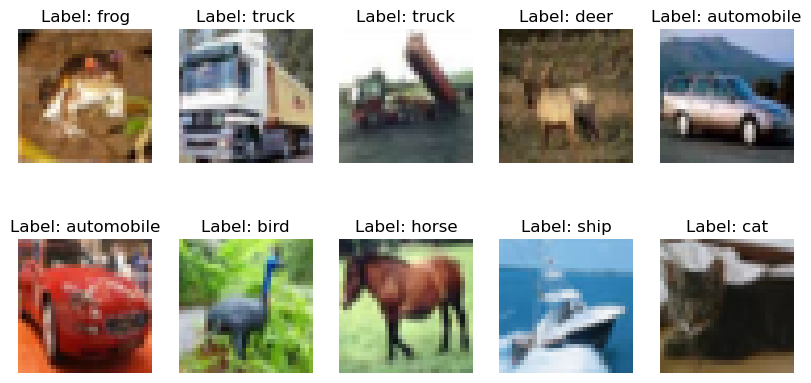

In [45]:
# combine all data
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# show the shape of the dataset and labels
print('Combined dataset shape:', X_all.shape, y_all.shape)

# create label-name dictionary
label_names = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
} 

# visualize some sample images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_all[i])
    ax.set_title(f'Label: {label_names[y_all[i][0]]}')
    ax.axis('off')

The input to a simple neural network must be a vector, which necessitates the transformation of these image tensors to a vector. Flattening these images will produce a vector of size (3072,) that can then be used as the input features to the neural network. As discussed previously, this destroys some information but is necessary for this model.

Another step that must be made is normalizing the elements of this vector. Normalization is the process of transforming all the data such that any data fall within a certain bound. Normalization does not add information but makes learning easier and more reliable. Integer inputs can lead to unecessarily large or uneven first layer activations. It also reduces the presence of global brightness differences, meaning that training can focus on learning relevant patterns rather than absolute intensity, potentially leading to improved generalizability.

In this case, the data will be normalized per channel as it will conserve the natural structure of the color data, which the neural network may leverage.

In [ ]:
from random import shuffle
# first, split data into train, validation, and test sets
# shuffle data
indices = list(range(X_all.shape[0]))
shuffle(indices) # inbuilt shuffle function
X_all = X_all[indices]
y_all = y_all[indices]

# split data
X_train = X_all[:40000]
y_train = y_all[:40000]
X_val = X_all[40000:50000]
y_val = y_all[40000:50000]
X_test = X_all[50000:]
y_test = y_all[50000:]

# get normalization parameters from training data
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))

# normalize datasets
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std


##### Post-Processing & Varification